# Setup

In [ ]:
!git clone https://github.com/aszala/VPEval.git
%cd VPEval

## Install requirements

In [ ]:
!pip install -q -r requirements.txt

In [ ]:
!pip install -q -r requirements_2.txt

## Install GroundingDINO

In [ ]:
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd GroundingDINO/
!pip install -e .
%cd ..

### Test to make sure GroundingDINO was properly installed.

If you get an error on the below line, please restart your runtime and then resume the notebook from the below cell (i.e., you don't need to reinstall all the above requirements)

In [ ]:
import groundingdino

Uncomment and run below cell if you had to restart the runtime

In [ ]:
### Uncomment and run below command if you had to restart the runtime
# %cd VPEval

### Download GroundingDINO weights

In [ ]:
!bash scripts/download_grounding_dino_weights.sh

# Inference

In [ ]:
%cd src

Write the image caption and extract the VPEval progams via ChatGPT

In [2]:
image_prompt = "an image of ten dogs"

In [3]:
from open_ended_prompt_generation.generate_open_ended_prompts import get_question_and_answers
import openai
openai.api_key = 'YOUR_API_KEY'

programs = get_question_and_answers({"caption": image_prompt, "output": "" })["output"]
programs

"objectEval(image, 'dog');vqa(image, 'what animals are in the image?', 'dogs,cats,birds,fish', 'dogs');countEval(objDet(image, 'dog'), '==10');vqa(image, 'how many dogs are in the image?', '1,2,3,4,5,6,7,8,9,10', '10');vqa(image, 'is this an image?', 'yes,no', 'yes');vqa(image, 'is this an image, a painting, or a sculpture?', 'image,painting,sculpture,photograph', 'image')"

Setup VPEval

- Please note that for demo purposes, `enable_vqa_module` is current set to `False` so all VQA modules above will be skipped, you can enable if you want to evaluate those

In [16]:
import os
import argparse
import torch
from accelerate.utils import set_seed
import random
import numpy as np

os.environ["TOKENIZERS_PARALLELISM"] = "false"

parser = argparse.ArgumentParser()

parser.add_argument("--enable_vqa_module", action="store_true")
parser.add_argument("--device", type=str, default="cuda")
parser.add_argument("--seed", type=int, default=10)
parser.add_argument("--use_obj_vqa", action="store_true")
parser.add_argument("--visualization_savepath", type=str, default="./results/visualizations/")

## GroundingDino Args
parser.add_argument("--grounding_dino_config_path", type=str, default="./dino/groundingdino/config/GroundingDINO_SwinT_OGC.py")
parser.add_argument("--grounding_dino_weights_path", type=str, default="../weights/groundingdino_swint_ogc.pth")

## EasyOCR Args
parser.add_argument("--ocr_langauge", type=str, default="en")

args, _ = parser.parse_known_args()


set_seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)
random.seed(args.seed)
np.random.seed(args.seed)

In [17]:
from evaluation_functions import EvaluationModules
import shutil
from IPython.display import Image, display


class EvaluationModel:
    def __init__(self, args):
        self.evaluator = EvaluationModules(args)
        self.module_names = EvaluationModules.get_evaluation_functions()

        self.enable_vqa_module = args.enable_vqa_module

        self.module_weights = {
            "self.evaluator.objectEval": 1,
            "self.evaluator.countEval": 1,
            "self.evaluator.textEval": 1,
            "self.evaluator.spatialEval": 1,
            "self.evaluator.scaleEval": 1,
            "self.evaluator.vqa": 1
        }

        self.module_scores = { }

        self.image_visualizations = []
        self.text_visualizations = []

    def evaluate(self, image_path, model_output):
        for mod in self.module_names:
            model_output = model_output.replace(mod, f"self.evaluator.{mod}")

        image_id = image_path.split("/")[-1].replace(".png", "").replace(".jpg", "")
        self.module_scores[image_id] = {}

        correct = 0
        total = 0

        evals = model_output.split(";")

        for i, eval in enumerate(evals):
            if not self.enable_vqa_module:
                if "vqa(" in eval:
                    continue
            
            # try:
            l_dict = {
                "image": image_path,
                "self": self
            }
            module_name = eval.split("(")[0].strip()
            weight = self.module_weights[module_name]
            
            eval = eval.replace("iamge", "image")
            eval = eval.replace("\\\\", "").replace("\\", "")
            eval = eval.replace(" '", " \"").replace("',", "\",").replace("')", "\")")
            
            exec(f"x = {eval}", globals(), l_dict)

            x = l_dict["x"]

            self.module_scores[image_id][eval] = x
            
            self.evaluator.visual_explainations[f"{image_id}_{i}"] = self.evaluator.visual_explainations[image_id]
            if self.evaluator.visual_explainations[f"{image_id}_{i}"]["visual_explaination"] == "n/a":
                pass
            else:
                new_image_path = f"{self.evaluator.args.visualization_savepath}/images/{image_id}_{i}.png"
                shutil.move(self.evaluator.visual_explainations[f"{image_id}_{i}"]["visual_explaination"], new_image_path)
                
                self.image_visualizations.append(Image(filename=new_image_path))
            
            self.text_visualizations.append(self.evaluator.visual_explainations[f"{image_id}_{i}"]["text_explaination"])

            if x:
                correct += weight
            total += weight
            # except Exception as ex:
            #     print(ex)
            #     continue

            del self.evaluator.visual_explainations[f"{image_id}"]
            
        return (correct / total)

In [18]:
evaluation_model = EvaluationModel(args)

final text_encoder_type: bert-base-uncased
_IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])


## Run the evaluation programs the image

In [19]:
vpeval_score = evaluation_model.evaluate(f'../assets/dogs.jpg', programs)
print("Image VPEval Score:", vpeval_score)
print("Per Module Result:", evaluation_model.module_scores)

0.5


# Visualize errors

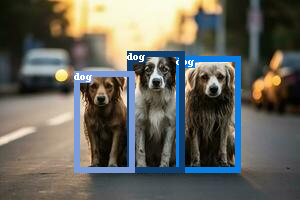

"dog" object found.


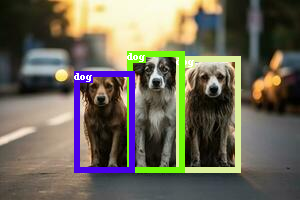

There are 3 "dog" objects, not 10.


In [20]:
for i in range(len(evaluation_model.image_visualizations)):
    display(evaluation_model.image_visualizations[i])
    print(evaluation_model.text_visualizations[i])